In [1]:
import os
import re
import datetime
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# I. Data engineering

### 1. Define utils funtions

In [2]:
# Helper function for Woe encoder
def char_bin(Y, X):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X', 'Y']][df1.X.isnull()]
    notmiss = df1[['X', 'Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X', as_index=True)

    d3 = pd.DataFrame({}, index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE': np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT / d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT / d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT - d3.DIST_NON_EVENT) * np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE',
             'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT', 'DIST_NON_EVENT', 'WOE', 'IV']]
    
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)\
    
    return (d3)

# Calculate gini score function
def gini(df, c, label):
    if c != label:
        #         return roc_auc_score(df[c], df[label]) *2 -1
        a = pd.DataFrame(df[c].value_counts()).reset_index().rename(
                                            columns={'index': c, c: 'count'})
        b = pd.DataFrame(df.groupby([c])[label].sum()).reset_index()
        a = a.merge(b, how='outer', left_on=c, right_on=c)
        a = a.sort_values(by=[c], ascending=False)
        a['day'] = a[label].cumsum() / a[label].sum()
        a['chieucao'] = a['count'] / a['count'].sum()
        a['day2'] = a['day'] + a['day'].shift(periods=1, fill_value=0)
        a['area'] = (a['day2'] * a['chieucao']) / 2
        print(c, 2 * a['count'].sum() * (a['area'].sum() - 0.5) / 
                                  (a['count'].sum() - a[label].sum()))


# Fill nan value function
def fill_nan(df, fea):
    for i in fea:
        if df[i].dtype == object:
            df[i].fillna('hihi', inplace=True)
        else:
            df[i].fillna(-2, inplace=True)
    return df

### 2. Read input data

In [3]:
print(os.listdir("../input"))

df_train = pd.read_csv('../input/kadata/train.csv')
df_test = pd.read_csv('../input/kadata/test.csv')
df = pd.concat((df_train, df_test), axis=0, sort=False)
df.info()

['kadata']


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Columns: 195 entries, id to Field_82
dtypes: float64(134), int64(2), object(59)
memory usage: 109.8+ MB


### 3. Feature engineering

#### Split groups of features 
Dữ liệu của cuộc thi với gần 200 trường được ghép từ hai nguồn khác nhau nên có rất nhiều trường chứa đến 50% là giá trị nan. Các feature sẽ được chia thành các nhóm khác nhau để dễ xử lý

In [4]:
# all date features
fea_date = [ 'Field_1','Field_2', 'Field_43', 'Field_44', 
            'Field_5', 'Field_6', 'Field_7', 'Field_8',
            'Field_9', 'Field_11', 'Field_15', 'Field_25',
            'Field_32', 'Field_33', 'Field_34','Field_35',
            'Field_40', 'F_startDate', 'F_endDate', 'E_startDate',
            'E_endDate', 'C_startDate', 'C_endDate', 'G_startDate',
            'G_endDate', 'A_startDate', 'A_endDate']

# all partner-features
fea_partner = ['partner0_B', 'partner0_K', 'partner0_L', 'partner1_B',
               'partner1_D', 'partner1_E', 'partner1_F', 'partner1_K',
               'partner1_L', 'partner2_B', 'partner2_G', 'partner2_K',
               'partner2_L', 'partner3_B', 'partner3_C', 'partner3_F',
               'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L',
               'partner4_A', 'partner4_B', 'partner4_C', 'partner4_D',
               'partner4_E', 'partner4_F', 'partner4_G', 'partner4_H',
               'partner4_K', 'partner5_B', 'partner5_C', 'partner5_H',
               'partner5_K', 'partner5_L', 'partner0_A', 'partner0_C',
               'partner0_F', 'partner0_G', 'partner0_H', 'partner1_A',
               'partner1_C', 'partner1_G', 'partner1_H', 'partner2_A',
               'partner2_C', 'partner2_D', 'partner2_E', 'partner2_F',
               'partner2_H', 'partner3_A', 'partner3_D', 'partner3_E',
               'partner4_L', 'partner5_A', 'partner5_D', 'partner5_E',
               'partner5_F', 'partner5_G', 'partner0_D', 'partner0_E',]

# List usefull partner-feature
fea_selected_partner = ['partner0_B', 'partner0_A', 'partner0_H', 'partner1_G',
                        'partner1_C', 'partner1_A', 'partner2_A', 'partner3_A',
                        'partner3_D', 'partner4_L', 'partner5_A']

# List all category-features which have few unique values 
fea_cat_1 = ['Field_4', 'namSinh', 'gioiTinh', 'Field_38',
             'Field_47', 'Field_62', 'info_social_sex', 'Field_82',
             'Field_12', 'Field_65', 'Field_66']

# List all category-features which have many unique values 
fea_cat_2 = ['Field_18', 'diaChi', 'Field_36', 'Field_45', 
             'Field_46', 'Field_48', 'Field_49', 'Field_54',
             'Field_55', 'Field_56', 'Field_61', 'Field_68',
             'maCv', 'data.basic_info.locale', 'currentLocationCity', 
             'currentLocationCountry', 'currentLocationName', 
             'currentLocationState', 'homeTownCity', 'homeTownCountry', 
             'homeTownName', 'homeTownState', 'brief']


# List all float-features
fea_float = [c for c in df.columns 
             if c not in ['id', 'label']and \
                c not in fea_date + fea_cat_1 + fea_cat_2 + fea_partner]

# List usefull float-features
fea_selected_float = [ c for c in fea_float 
                  if c not in [ 'Field_14','Field_16','Field_17', 'Field_24',
                                'Field_26', 'Field_30', 'Field_31', 'Field_37', 
                                'Field_52', 'Field_57', 'A_numQuery', 'C_numQuery', 
                                'E_numQuery', 'F_numQuery', 'G_numQuery']]


#### Process Date features
Đôi với fea_date: Các feature ngày tháng gần như không có tác dụng giúp tăng CV của model. Nhóm biến đổi các feature này thành dạng quarter và datediff để sử dụng

In [5]:
# Get quarter-features from date
for c in fea_date:
    if c not in ['Field_34']:
        df['quarter_' + c] = pd.to_datetime(df[c]).dt.quarter

fea_quater = [c for c in df.columns if c.startswith('quarter_')]
fea_notdate = [c for c in df.columns if c not in fea_date]

df = fill_nan(df, fea_notdate)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73411 entries, 0 to 20380
Columns: 221 entries, id to quarter_A_endDate
dtypes: float64(160), int64(2), object(59)
memory usage: 124.3+ MB


In [6]:
# Get datediff features

df['diff4'] = (pd.to_datetime(df['Field_44']) -
               pd.to_datetime(df['Field_43'])).dt.seconds / 3600
df = fill_nan(df, ['diff4'])
gini(df=df[:53030], c='diff4', label='label')

df['diff2'] = (pd.to_datetime(df['Field_2']) -
               pd.to_datetime(df['Field_1'])).dt.seconds / 3600
df = fill_nan(df, ['diff2'])
gini(df=df[:53030], c='diff2', label='label')

diff4 -0.07471314206329183
diff2 -0.08219465498813852


#### Other features
Làm sạch dữ liệu đối với một số categorical features

In [7]:
# Process diaChi field
df.loc[(df['diaChi'].str.upper().str.count('XÃ') == 1), 't_diachi'] = 2
df.loc[(df['diaChi'].str.upper().str.count('THỊ TRẤN') == 1), 't_diachi'] = 3
df.loc[(df['diaChi'].str.upper().str.count('PHƯỜNG') == 1), 't_diachi'] = 4
df.loc[(df['diaChi'].str.upper().str.count('CTY') == 1) |
       (df['diaChi'].str.upper().str.count('CÔNG TY') == 1), 't_diachi'] = 1
df.loc[(df['diaChi'].str.upper().str.count('TT DỊCH') == 1), 't_diachi'] = 5
df.loc[(df['diaChi'].str.upper().str.count('TT GIỚI') == 1), 't_diachi'] = 5
df.loc[(df['diaChi'].str.upper().str.count('HIHI') == 1), 't_diachi'] = -2
df['t_diachi'].fillna(5, inplace=True)

gini(df=df[:53030], c='t_diachi', label='label')


# Process Field_55
df.loc[(df['Field_55'] == 'hihi'), 't_Field_55'] = -2
df.loc[(df['Field_55'] == 'YN'), 't_Field_55'] = 1
df.loc[(df['Field_55'] == 'BI'), 't_Field_55'] = 2
df.loc[(df['Field_55'] == 'BO'), 't_Field_55'] = 3
df.loc[(df['Field_55'] == 'TA'), 't_Field_55'] = 4
df['t_Field_55'].fillna(3.5, inplace=True)

gini(df=df[:53030], c='t_Field_55', label='label')


# Process Field_56
df.loc[(df['Field_56'] == 'hihi'), 't_Field_56'] = -2
df.loc[(df['Field_56'] == 'Doanh nghiệp có vốn đầu tư nước ngoài'), 't_Field_56'] = 1
df.loc[(df['Field_56'] ==
        'Là những người thuộc hộ gia đình, trừ các đối tượng trên'), 't_Field_56'] = 2
df.loc[(df['Field_56'] == 'Người đang hưởng trợ cấp thất nghiệp'), 't_Field_56'] = 4
df.loc[(df['Field_56'] == 'Ngoài quốc doanh Tỉnh/TP'), 't_Field_56'] = 3
df.loc[(df['Field_56'] == 'Ngoài quốc doanh Quận 1'), 't_Field_56'] = 5
df['t_Field_56'].fillna(4.5, inplace=True)

gini(df=df[:53030], c='t_Field_56', label='label')


# Field 62 65
df.loc[(df['Field_62'] == 'Ngoài quốc doanh Quận 7'), 'Field_62'] = 'hihi'
df.loc[(df['Field_65'] == '5'), 'Field_65'] = 'hihi'

# Transform Long latitude features
for c in ['currentLocationLatitude', 'currentLocationLongitude',
          'homeTownLatitude', 'homeTownLongitude']:
    df['t_' + c] = df[c]
    df['t_' + c] = df['t_' + c].replace(-2, -999)
    df['t_' + c] = df['t_' + c].replace(0, -888)


t_diachi -0.09183517654943324
t_Field_55 -0.09940356787283643
t_Field_56 -0.10100835433906546


#### Process maCv field
Đối với feature ma_Cv, nhóm có sử dụng code của các team đã chia sẻ (thanks ^^)

In [8]:
def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

def get_job_category(x):
    if isinstance(x, str):
        if "công nhân" in x or "cnv" in x or "cn" in x or "may công nghiệp" in x or "lao động" in x\
                or "thợ" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x or "c.n" in x or "lđ" in x:
            return "CN"
        elif "giáo viên" in x or "gv" in x or "gíao viên" in x:
            return "GV"
        elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x or "cb" in x or "nhõn viờn" in x:
            return "NV"
        elif "tài xế" in x or "lái" in x or "tài xê" in x:
            return "TX"
        elif "quản lý" in x or "phó phòng" in x or "hiệu phó" in x:
            return "QL"
        elif "undefined" in x:
            return "missing"
        elif "giám đốc" in x or "hiệu trưởng" in x:
            return "GĐ"
        elif "phục vụ" in x:
            return "PV"
        elif "chuyên viên" in x:
            return "CV"
        elif "bác sĩ" in x or "dược sĩ" in x or "y sĩ" in x or "y sỹ" in x:
            return "BS"
        elif "y tá" in x:
            return "YT"
        elif "hộ sinh" in x:
            return "HS"
        elif "chủ tịch" in x:
            return "CT"
        elif "bếp" in x:
            return "ĐB"
        elif "sư" in x:
            return "KS"
        elif "dưỡng" in x:
            return "ĐD"
        elif "kỹ thuật" in x or "kĩ thuật" in x:
            return "KTV"
        elif "diễn viên" in x:
            return "DV"
        else:
            return "missing"
    else:
        return x


def process_maCv(df):
    df["maCv_processed"] = df["maCv"].apply(str_normalize).apply(
        get_job_category).astype("category")
    return df


df = process_maCv(df)

### 4. Creating new features

#### Creating new features by combining group of features
Tạo thêm các features mới: do nhiều features đã bị giấu tên và ý nghĩa nên nhìn chung sẽ khó khăn cho việc tạo thêm các features, nhóm dã tạo thêm các features một cách thuần túy theo data science (cộng, trừ, nhân, chia, count,và các thước đo thống kê khác....) mà không cần quan tâm quá nhiều ý nghĩa về mặt bussiness. Qua nhiều lần thử, các features sau đây giúp tăng CV và được lựa chọn


In [9]:

df['a_diff'] = (pd.to_datetime(df['A_endDate']) - pd.to_datetime(df['A_startDate'])).dt.days
df['a_chia'] = df['A_numOrg'] / ((df['a_diff']) + 1)
df['a_chiaq'] = df['A_numQuery'] / ((df['a_diff']) + 1)
gini(df=df[:53030], c='a_diff', label='label')
gini(df=df[:53030], c='a_chia', label='label')
gini(df=df[:53030], c='a_chiaq', label='label')

df['c_diff'] = (pd.to_datetime(df['C_endDate']) - pd.to_datetime(df['C_startDate'])).dt.days
df['c_chia'] = df['C_numOrg'] / ((df['c_diff']) + 1)
df['c_chiaq'] = df['C_numQuery'] / ((df['c_diff']) + 1)
gini(df=df[:53030], c='c_diff', label='label')
gini(df=df[:53030], c='c_chia', label='label')
gini(df=df[:53030], c='c_chiaq', label='label')

df['e_diff'] = (pd.to_datetime(df['E_endDate']) - pd.to_datetime(df['E_startDate'])).dt.days
df['e_chia'] = df['E_numOrg'] / ((df['e_diff']) + 1)
df['e_chiaq'] = df['E_numQuery'] / ((df['e_diff']) + 1)
gini(df=df[:53030], c='e_diff', label='label')
gini(df=df[:53030], c='e_chia', label='label')
gini(df=df[:53030], c='e_chiaq', label='label')

df['f_diff'] = (pd.to_datetime(df['F_endDate']) - pd.to_datetime(df['F_startDate'])).dt.days
df['f_chia'] = df['F_numOrg'] / ((df['f_diff']) + 1)
df['f_chiaq'] = df['F_numQuery'] / ((df['f_diff']) + 1)
gini(df=df[:53030], c='f_diff', label='label')
gini(df=df[:53030], c='f_chia', label='label')
gini(df=df[:53030], c='f_chiaq', label='label')

df['g_diff'] = (pd.to_datetime(df['G_endDate']) - pd.to_datetime(df['G_startDate'])).dt.days
df['g_chia'] = df['G_numOrg'] / ((df['g_diff']) + 1)
df['g_chiaq'] = df['G_numQuery'] / ((df['g_diff']) + 1)
gini(df=df[:53030], c='g_diff', label='label')
gini(df=df[:53030], c='g_chia', label='label')
gini(df=df[:53030], c='g_chiaq', label='label')\


feature_combine_Org_Query = [ 'a_chiaq', 'c_chiaq', 'e_chiaq',
                             'f_chiaq', 'g_chiaq']
df = fill_nan(df, feature_combine_Org_Query)

a_diff -0.06524876980941756
a_chia 0.09925590996710497
a_chiaq 0.10538479275981105
c_diff -0.0330911425742302
c_chia 0.035472703705602036
c_chiaq 0.037928205129006444
e_diff -0.016576830858975714
e_chia 0.02978445290443516
e_chiaq 0.03147048306613091
f_diff -0.012964438690420932
f_chia 0.02594709870414238
f_chiaq 0.03217637587117908
g_diff 0.05452460806877444
g_chia -0.04972659861485636
g_chiaq -0.03903320291969942


#### Create new features by squaring float features

Các float features chứa rất nhiều giá trị NaN có thể dẫn đến sự thiếu ổn định cho model, nhóm tạo thêm các feature mới bằng cách count encoder và square encoder, điều này sẽ giúp tăng CV và tính ổn định của model

In [10]:
# ------fea square-------
fea_sq = []
for c in fea_selected_float:
    if df[c].nunique() > 6:
        df['sq_' + c] = df[c] * df[c]
        gini(df=df[:53030], c='sq_' + c, label='label')
        fea_sq.append('sq_' + c)

sq_Field_10 0.06663422656545517
sq_Field_19 0.039990085941210646
sq_Field_20 -0.09559422294158129
sq_Field_23 -0.08909545976870743
sq_Field_27 0.07590533459690467
sq_Field_28 0.07545045249328874
sq_Field_29 -0.03298561631683494
sq_ngaySinh -0.054994885655191304
sq_Field_59 -0.07637629987652846
sq_Field_60 -0.06267391700447585
sq_Field_63 -0.019022647543684677
sq_Field_64 0.03567800866435558
sq_Field_67 -0.08248773258543363
sq_Field_69 0.06320372521585511
sq_Field_70 0.055411845443820315
sq_Field_71 0.05742128448695953
sq_Field_72 0.07752662652931655
sq_Field_74 0.052498774438326797
sq_Field_75 -0.04402901377346885
sq_Field_76 0.041684532663063614
sq_Field_77 -0.03878796712375375
sq_friendCount -0.008477591929350601
sq_subscriberCount 0.017155388837366274
sq_currentLocationLocationId -0.04934733952523115
sq_currentLocationLatitude -0.04585993416374538
sq_currentLocationLongitude -0.05155116514427275
sq_homeTownLocationId -0.03922729843274913
sq_homeTownLatitude -0.035264589869218696
sq_

#### Creating new features use count-encoder

In [11]:
fea_float_count = []
for c in fea_selected_float:
    if df[c].nunique() > 6:
        a = pd.DataFrame(df[c].value_counts()). \
                        reset_index(). \
                        rename(columns={'index': c, 
                                        c: 'count_' + c})
        df = pd.merge(df, a, left_on=c, right_on=c, how='left')
        fea_float_count.append('count_' + c)
        
print("Number of float feauture columns:", len(fea_float_count))


Number of float feauture columns: 41


### 5. Encoding methods

#### Label encoder for category-features


In [12]:
for i in fea_cat_2 + fea_cat_1:
    df[i] = df[i].astype(str)
label_encoder = LabelEncoder()
for col in fea_cat_2 + fea_cat_1:
    df['la_' + col] = label_encoder.fit_transform(df[col])

la_fea_cat_2 = ['la_' + c for c in fea_cat_2]
la_fea_cat_1 = ['la_' + c for c in fea_cat_1]

for c in la_fea_cat_2:
    gini(df=df[:53030], c=c, label='label')

la_Field_18 0.00995574721022629
la_diaChi 0.06727506751614756
la_Field_36 0.07774480430928683
la_Field_45 0.07830739998430221
la_Field_46 0.07255697115109366
la_Field_48 0.07096227199764718
la_Field_49 0.0689795588288203
la_Field_54 0.02924662788642936
la_Field_55 0.07851046897765666
la_Field_56 0.06352216651409645
la_Field_61 0.07363693473042338
la_Field_68 0.0850851441497534
la_maCv 0.01991407088346631
la_data.basic_info.locale -0.07989037524514334
la_currentLocationCity 0.0733449153232943
la_currentLocationCountry 0.0738527628024153
la_currentLocationName 0.05892638089511671
la_currentLocationState 0.06729705289569245
la_homeTownCity 0.06742926258355385
la_homeTownCountry 0.06809996125709467
la_homeTownName 0.059795158308075115
la_homeTownState 0.05823496371255573
la_brief -0.10140233135462301


#### WoE encoder for category-features
Thực hiện WOE encoder đối với một số categorical features,qua nhiều lần thử nhóm nhận thấy chỉ có một số biến dưới đây có thể giúp tăng CV

In [13]:
fea_cat_2_woe = []
for c in ['Field_18', 'Field_36', 'Field_54', 'Field_61',
          'data.basic_info.locale', 'currentLocationState',
          'homeTownCountry']:
    if df[c].nunique() < 1:
        print(c + ':big:',
              len(Series.unique(df[c])),
              len(Series.unique(df[:53030][c])))
    else:
        conv = char_bin(df[:53030].label, df[:53030][c])
        df = pd.merge(df, conv[['MIN_VALUE', 'WOE']], how='left', left_on=c, right_on='MIN_VALUE'). \
                        rename(columns={'WOE': 'w_' + c}).drop('MIN_VALUE', axis=1)
        gini(df=df[:53030], c='w_' + c, label='label')
        print(df[c].nunique(), df['w_' + c].nunique())
        fea_cat_2_woe.append('w_' + c)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


w_Field_18 0.036498281860663236
8728 31
w_Field_36 0.10230690320016794
35 28
w_Field_54 0.03368353381041859
50 23
w_Field_61 0.11288983512122115
37 32
w_data.basic_info.locale 0.08865003072103528
28 13
w_currentLocationState 0.08566040853002233
236 74
w_homeTownCountry 0.07051868492385169
45 16


#### One hot encoding

Nhóm sử dụng onehot-encoder cho một số categorical features, quá trình cho thấy sử dụng onehotencode cho các categorical features (có lượng category không quá lớn) sẽ giúp model ổn định và tránh overfit, nhất là đối với dữ liệu nhiều nan như Kalapa.

Qua quá trình thử nghiệm team nhận thấy khi thay đổi tham số drop_first của one_hot_encoder, dữ liệu sau khi encode cho kết quả của mô hình có sự khác nhau cả CV và LB,
sau khi blending 2 model kết quả được cãi thiện rõ rệt nên team đã sử dụng blend model cho 2 nhóm dữ liệu one hot encoder.

In [14]:
onehotvar = la_fea_cat_1 + ['la_brief', 'w_Field_61',
                            'w_data.basic_info.locale',
                            'w_currentLocationState']
dumf = ['dum_' + c for c in onehotvar]


dummies_without_drop = pd.get_dummies(df, columns=onehotvar, prefix=dumf,
                         drop_first=False, sparse=True)

dummies_with_drop = pd.get_dummies(df, columns=onehotvar, prefix=dumf,
                         drop_first=True, sparse=True)

dumvar_without_drop = [c for c in dummies_without_drop.columns if c.startswith('dum_')]
dumvar_with_drop = [c for c in dummies_with_drop.columns if c.startswith('dum_')]

# II. Modeling

Kết thúc phần xử lý dữ liệu và tạo biến, đối với phần modelling, nhóm sử dụng model quen thuộc cho các bài toán dạng này: lightgbm. Khi sử dụng lightgbm, thách thức nhất là quá trình finetune parametter. Do đặc thù dữ liệu có nhiều giá trị NaN, để model ổn định, nhóm chỉ sử dụng model lgb với max_depth và num_leaves thấp để tránh overfit. Thêm vào đó, model sẽ được train them 3 random seed khác nhau để tăng tính ổn định

## 1. The first model using one-hot-encoder without drop_first 
#### Use dummies_without_drop variable 

#### Setting model parameters

In [15]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.8,
    'boost_from_average': 'false',
    'scale_pos_weight': 1,
    'boost': 'gbdt',
    'feature_fraction': 0.8,
    'learning_rate': 0.01,
    'max_depth': 8,
    'metric': 'auc',  # cross_entropy binary_logloss auc
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 64,
    'num_threads': 8,
    'tree_learner': 'serial',  # serial feature data voting
    'objective': 'binary',
    'verbosity': 1,
    'max_bin': 255,
    'min_gain_to_split': 0,
}
nf = 5

#### Getting training features

In [16]:
df_train1 = dummies_without_drop[:53030]
df_test1 = dummies_without_drop[53030:]
X_train = df_train1
X_test = df_test1
target = X_train.label
group = X_train.label.astype(str)

features = [c for c in fea_selected_float + dumvar_without_drop + \
            feature_combine_Org_Query + fea_selected_partner + fea_float_count + \
            ['w_Field_18', 't_diachi', 'w_Field_36', 'w_Field_54',
             't_Field_55', 't_Field_56', 'maCv_processed', 'la_currentLocationCity',
             'la_currentLocationCountry', 'la_currentLocationName', 'la_homeTownCity',
             'w_homeTownCountry', 'la_homeTownName', 'la_homeTownState',
             'diff2', 'diff4', 'quarter_F_startDate', 'quarter_F_endDate',
             'quarter_E_startDate', 'quarter_E_endDate', 'quarter_C_startDate',
             'quarter_C_endDate', 'quarter_G_startDate', 'quarter_G_endDate',
             'quarter_A_startDate', 'quarter_A_endDate', 't_currentLocationLatitude',
             't_currentLocationLongitude', 't_homeTownLatitude', 't_homeTownLongitude'] \
            + fea_sq if c not in ['currentLocationLatitude', 'currentLocationLongitude', 
                                  'homeTownLatitude', 'homeTownLongitude']]

print( 'num of features for model:', len(features), X_train[features].shape,
                                      X_test[features].shape, target.shape)

num of features for model: 384 (53030, 384) (20381, 384) (53030,)


#### Training model 1

In [17]:
# Set list of seeds
states = [42, 11, 100]
AR = []
predictions = np.zeros(len(X_test))


# Training
for random_state in states:
    print('-' * 30)
    param['random_state'] = random_state
    folds = StratifiedKFold(n_splits=nf, shuffle=True, random_state=random_state)
    a = folds.split(X_train.values, group.values)
    aucavg = []
    oof = np.zeros(len(X_train))
    pre = pd.DataFrame()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(a):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx])
        
        val_data = lgb.Dataset(X_train.iloc[val_idx][features], label=target.iloc[val_idx])
        
        clf = lgb.train(param, trn_data, 5000, valid_sets=[trn_data, val_data],
                        verbose_eval=200, early_stopping_rounds=500)
        
        oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], \
                                   num_iteration=clf.best_iteration)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        pre['fold_' + str(fold_)] = clf.predict(X_test[features], num_iteration=clf.best_iteration)  # folds.n_splits
        predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) \
                            / (nf * len(states))
        aucavg.append(roc_auc_score(target.iloc[val_idx], oof[val_idx]))
        print(roc_auc_score(target.iloc[val_idx], oof[val_idx]))
        
    print("CV score: {:<8.8f}".format(roc_auc_score(target, oof)))
    print("CV score AR: {:<8.8f}".format(2 * roc_auc_score(target, oof) - 1))
    print('AUC mean: %.6f' % np.mean(aucavg))
    print('AR mean: {:<8.8f}'.format(2 * np.mean(aucavg) - 1))
    print('AUC std:{:<8.8f}'.format(2 * np.std(aucavg)))

    cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean()
            .sort_values(by="importance", ascending=False)[:30].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    AR.append(2 * roc_auc_score(target, oof) - 1)
    
print(AR)
print('CV mean Gini', np.mean(AR))


------------------------------
Fold 0
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.779108	valid_1's auc: 0.739426
[400]	training's auc: 0.806636	valid_1's auc: 0.748768
[600]	training's auc: 0.824378	valid_1's auc: 0.752298
[800]	training's auc: 0.839041	valid_1's auc: 0.753708
[1000]	training's auc: 0.850427	valid_1's auc: 0.754175
[1200]	training's auc: 0.860957	valid_1's auc: 0.754459
[1400]	training's auc: 0.871463	valid_1's auc: 0.754698
[1600]	training's auc: 0.880089	valid_1's auc: 0.754731
[1800]	training's auc: 0.887427	valid_1's auc: 0.754473
[2000]	training's auc: 0.894655	valid_1's auc: 0.754266
Early stopping, best iteration is:
[1534]	training's auc: 0.877028	valid_1's auc: 0.754773
0.7547728097932521
Fold 1
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.776876	valid_1's auc: 0.753876
[400]	training's auc: 0.804288	valid_1's auc: 0.760545
[600]	training's auc: 0.822747	valid_1's auc: 0.762466


#### Getting submission 1

In [18]:
sub_df = pd.read_csv('../input/kadata/sample_submission.csv')
sub1 = pd.DataFrame({"id": sub_df.id.values})
sub1['label'] = predictions
sub1.to_csv("sub1.csv", index=False)
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean()
        .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

#### Plot feature important

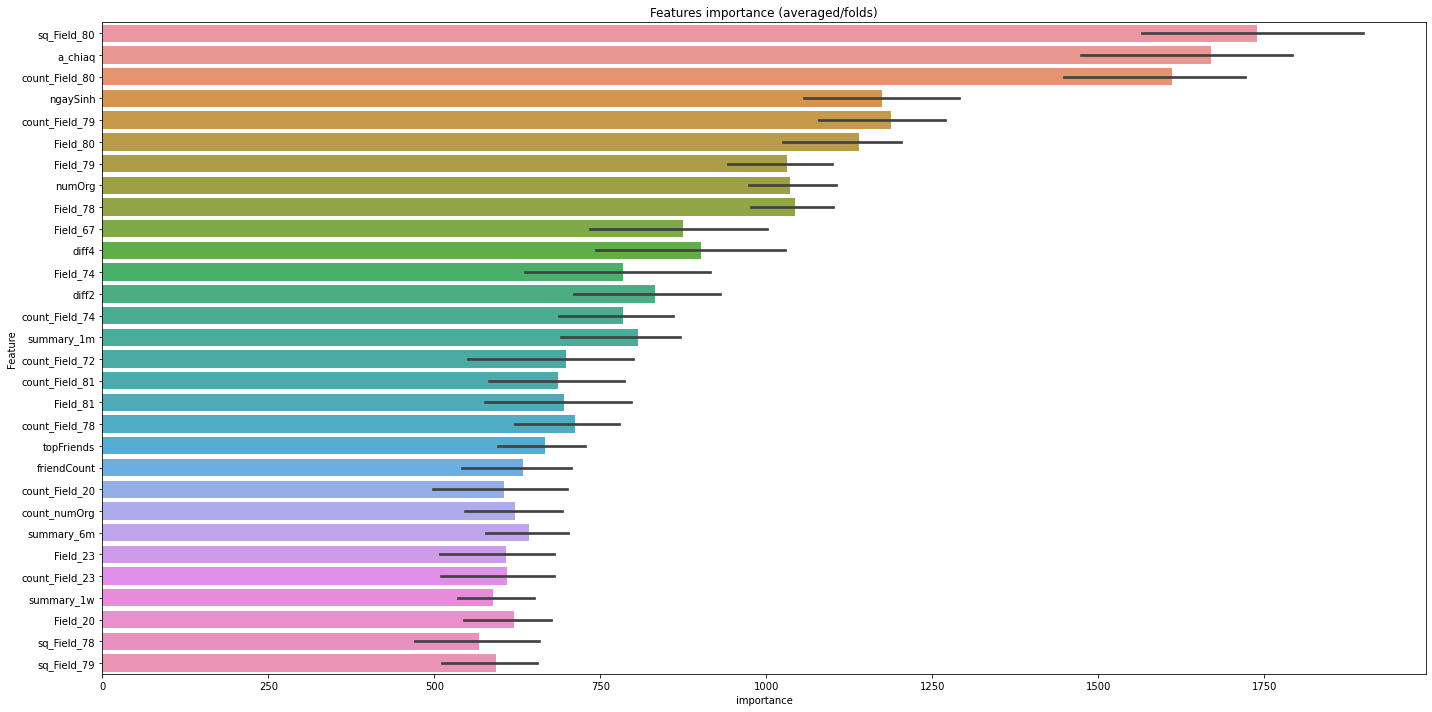

In [19]:
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="Feature",
            data=best_features.sort_values( by="importance",
                                           ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI1.png')

Kết quả model: CV 0.5210 và Public LB 0.5208, CV và LB khá tương đồng, tuy nhiên Private score chỉ đạt được 0.4476. Nhóm phỏng đoán dữ liệu Private LB khả năng chữa nhiều dữ liệu NaN hơn so với public LB và phân bố khác public LB, do đó model dự báo kém hơn rất nhiều trên Private LB cho dù CV và public LB đã khá tương đồng

## 2. The second model using one-hot-encoder with drop_first=True
#### Use dummies_with_drop variable 

Tiếp theo, nhóm có train thêm một model nữa để emsemble với model trên, nhóm chỉ thay đổi dropfirst=True trong cách tạo dummies features, còn lại các setup khác giữ lại. Model thứ 2 này được CV 0.5197 và LB 0.5200, private LB là 0.4448. Blend hai model với trọng sô 50-50 là kết quả được giải 3 của cuoc thi với LB 0.5215 và private 0.4473

#### Getting training features

In [20]:
df_train1 = dummies_with_drop[:53030]
df_test1 = dummies_with_drop[53030:]
X_train = df_train1
X_test = df_test1
target = X_train.label
group = X_train.label.astype(str)

features = [c for c in fea_selected_float + dumvar_with_drop + \
            feature_combine_Org_Query + fea_selected_partner + fea_float_count + \
            ['w_Field_18', 't_diachi', 'w_Field_36', 'w_Field_54',
             't_Field_55', 't_Field_56', 'maCv_processed', 'la_currentLocationCity',
             'la_currentLocationCountry', 'la_currentLocationName', 'la_homeTownCity',
             'w_homeTownCountry', 'la_homeTownName', 'la_homeTownState',
             'diff2', 'diff4', 'quarter_F_startDate', 'quarter_F_endDate',
             'quarter_E_startDate', 'quarter_E_endDate', 'quarter_C_startDate',
             'quarter_C_endDate', 'quarter_G_startDate', 'quarter_G_endDate',
             'quarter_A_startDate', 'quarter_A_endDate', 't_currentLocationLatitude',
             't_currentLocationLongitude', 't_homeTownLatitude', 't_homeTownLongitude'] \
            + fea_sq if c not in ['currentLocationLatitude', 'currentLocationLongitude', 
                                  'homeTownLatitude', 'homeTownLongitude']]

print( 'num of features for model:', len(features), X_train[features].shape,
                                      X_test[features].shape, target.shape)

num of features for model: 369 (53030, 369) (20381, 369) (53030,)


#### Training model 2

In [21]:
# Set list of seeds
states = [42, 11, 100]
AR = []
predictions = np.zeros(len(X_test))


# Training
for random_state in states:
    print('-' * 30)
    param['random_state'] = random_state
    folds = StratifiedKFold(n_splits=nf, shuffle=True, random_state=random_state)
    a = folds.split(X_train.values, group.values)
    aucavg = []
    oof = np.zeros(len(X_train))
    pre = pd.DataFrame()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(a):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx])
        
        val_data = lgb.Dataset(X_train.iloc[val_idx][features], label=target.iloc[val_idx])
        
        clf = lgb.train(param, trn_data, 5000, valid_sets=[trn_data, val_data],
                        verbose_eval=200, early_stopping_rounds=500)
        
        oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], \
                                   num_iteration=clf.best_iteration)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        pre['fold_' + str(fold_)] = clf.predict(X_test[features], num_iteration=clf.best_iteration)  # folds.n_splits
        predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) \
                            / (nf * len(states))
        aucavg.append(roc_auc_score(target.iloc[val_idx], oof[val_idx]))
        print(roc_auc_score(target.iloc[val_idx], oof[val_idx]))
        
    print("CV score: {:<8.8f}".format(roc_auc_score(target, oof)))
    print("CV score AR: {:<8.8f}".format(2 * roc_auc_score(target, oof) - 1))
    print('AUC mean: %.6f' % np.mean(aucavg))
    print('AR mean: {:<8.8f}'.format(2 * np.mean(aucavg) - 1))
    print('AUC std:{:<8.8f}'.format(2 * np.std(aucavg)))

    cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean()
            .sort_values(by="importance", ascending=False)[:30].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    AR.append(2 * roc_auc_score(target, oof) - 1)
    
print(AR)
print('CV mean Gini', np.mean(AR))


------------------------------
Fold 0
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.775327	valid_1's auc: 0.740087
[400]	training's auc: 0.803936	valid_1's auc: 0.749127
[600]	training's auc: 0.822436	valid_1's auc: 0.752234
[800]	training's auc: 0.837854	valid_1's auc: 0.753669
[1000]	training's auc: 0.849753	valid_1's auc: 0.754094
[1200]	training's auc: 0.86114	valid_1's auc: 0.754375
[1400]	training's auc: 0.871025	valid_1's auc: 0.754274
[1600]	training's auc: 0.88012	valid_1's auc: 0.754497
[1800]	training's auc: 0.887171	valid_1's auc: 0.754197
[2000]	training's auc: 0.894334	valid_1's auc: 0.754106
Early stopping, best iteration is:
[1655]	training's auc: 0.881959	valid_1's auc: 0.75463
0.7546297505684582
Fold 1
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.774225	valid_1's auc: 0.754307
[400]	training's auc: 0.802727	valid_1's auc: 0.761108
[600]	training's auc: 0.821208	valid_1's auc: 0.763552
[80

#### Getting submission 2

In [22]:
sub_df = pd.read_csv('../input/kadata/sample_submission.csv')
sub2 = pd.DataFrame({"id": sub_df.id.values})
sub2['label'] = predictions
sub2.to_csv("sub2.csv", index=False)
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean()
        .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

#### Plot feature important

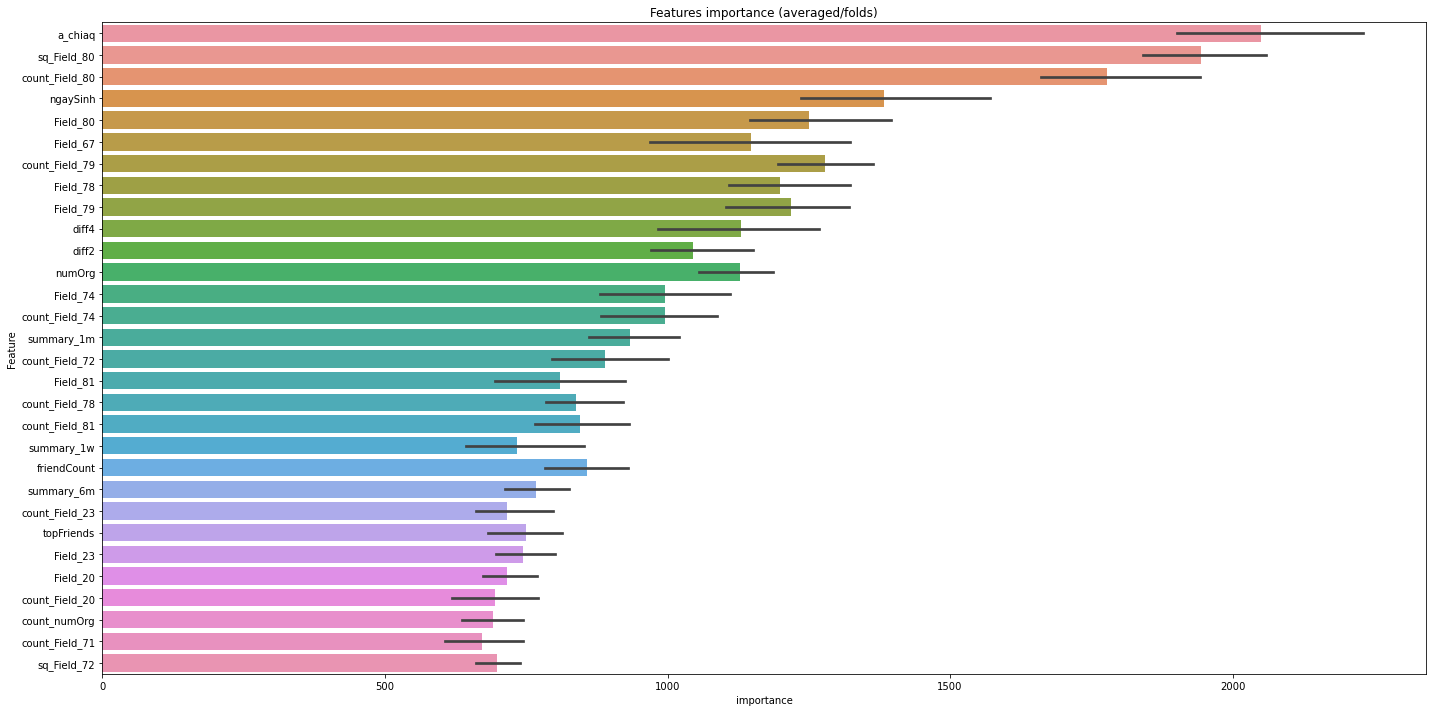

In [23]:
plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="Feature",
            data=best_features.sort_values( by="importance",
                                           ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI2.png')

## 3. Blending 2 model (weighting 50-50) 

In [24]:
sub = pd.DataFrame({"id": sub_df.id.values})
sub['label']=(sub1['label']+sub2['label'])/2
sub.to_csv("sub_final.csv", index=False)